<a href="https://colab.research.google.com/github/Psyrus7/AtharvaShinde_INBT04755_September2023/blob/main/Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import io
import os
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Defining an empty list to store data lines
data_lines = []

In [ ]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = r'/content/drive/MyDrive/Project/IMDB Dataset.csv'

In [ ]:
with open(dataset_path, "r", encoding="utf-8") as file:
    for line in file:
        data_lines.append(line)


csv_content = ''.join(data_lines)

try:
    imdb = pd.read_csv(io.StringIO(csv_content))
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

In [ ]:
print("Dataset Structure:")
print(imdb.info())

Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [ ]:
# Data Cleaning Tasks :

# Handling missing values (if any)
imdb.dropna(inplace=True)

# Removing duplicates
imdb.drop_duplicates(inplace=True)

# Verifing sentiment labels and address any inconsistencies
# ensuring sentiment labels are 'positive' and 'negative'
sentiment_distribution = imdb['sentiment'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_distribution)

# Save the cleaned dataset to a CSV file (optional)
imdb.to_csv('/content/drive/MyDrive/Project/cleaned_imdb.csv', index=False)


Sentiment Distribution:
positive    24884
negative    24698
Name: sentiment, dtype: int64


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(text):
    # Removing HTML tags and other special characters
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Converting text to lowercase
    text = text.lower()

    # Tokenizing the text
    words = word_tokenize(text)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]

    # Stem the words
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    # Join the words back into a single string
    preprocessed_text = ' '.join(stemmed_words)

    return preprocessed_text
# Creating the 'preprocessed_review' column in the DataFrame
imdb['preprocessed_review'] = ""
# Applying preprocessing to the 'review' column in batches
batch_size = 10000
num_batches = len(imdb) // batch_size + 1

for i in range(num_batches):
    batch_start = i * batch_size
    batch_end = (i + 1) * batch_size
    imdb['preprocessed_review'].iloc[batch_start:batch_end] = imdb['review'].iloc[batch_start:batch_end].apply(preprocess_text)





In [ ]:
import pandas as pd

# Load the preprocessed dataset
dataset_path = '/content/drive/MyDrive/Project/preprocessed_imdb.csv'
imdb = pd.read_csv(dataset_path)

# Concatenate the columns into a single 'preprocessed_review' column
imdb['preprocessed_review'] = imdb.iloc[:, 0:].apply(lambda x: ' '.join(x.astype(str)), axis=1)

# Save the preprocessed dataset to a CSV file (optional)
imdb.to_csv("/content/drive/MyDrive/Project/preprocessed_imdb.csv", index=False)

In [ ]:
print(imdb.columns)

Index(['review', 'sentiment', 'preprocessed_review'], dtype='object')


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import csv
import os
import re  # Import the re module for regular expressions

# Load the preprocessed dataset
dataset_path = '/content/drive/MyDrive/Project/preprocessed_imdb.csv'
imdb = pd.read_csv(dataset_path)

# Initializing the CountVectorizer
vectorizer = CountVectorizer()

# Fitting the vectorizer on the entire 'preprocessed_review' column
vectorizer.fit(imdb['preprocessed_review'])

# Defining batch size and initialize an empty CSR matrix to store tokenized reviews
batch_size = 500
tokenized_reviews = None

# Defining the directory where tokenized batch files are stored
batch_directory = '/content/drive/MyDrive/Project/'

# Checking if any tokenized batch files exist in the directory
existing_batches = [file for file in os.listdir(batch_directory) if re.match(r'tokenized_batch_\d+\.csv', file)]

# Initializing a variable to keep track of the latest batch number processed
latest_batch_number = 0

# If batch files are found, identify the latest batch number
if existing_batches:
    latest_batch_number = max([int(re.search(r'\d+', file).group()) for file in existing_batches])

# Set the starting batch number to the latest batch number found
starting_batch_number = latest_batch_number

# Tokenizing the 'preprocessed_review' column in batches
for batch_start in range(starting_batch_number, len(imdb), batch_size):
    batch_end = min(batch_start + batch_size, len(imdb))

    # Tokenizing the current batch of preprocessed reviews
    X_batch = vectorizer.transform(imdb['preprocessed_review'].iloc[batch_start:batch_end])

    # Convert the result to a dense NumPy array
    X_batch_dense = X_batch.toarray()

    # Concatenate the batch array with the tokenized_reviews array
    if tokenized_reviews is None:
        tokenized_reviews = X_batch_dense
    else:
        tokenized_reviews = np.vstack((tokenized_reviews, X_batch_dense))

    print(f"Tokenized {batch_end} rows, {len(imdb) - batch_end} rows remaining")

    # Check if the batch size is a multiple of 3000
    if (batch_end % 3000 == 0) and (batch_end != 0):
        # Save the tokenized batch to a CSV file
        batch_filename = f"/content/drive/MyDrive/Project/tokenized_batch_{batch_end}.csv"
        pd.DataFrame(tokenized_reviews, columns=vectorizer.get_feature_names_out()).to_csv(batch_filename, index=False)

        # Clear the memory by resetting tokenized_reviews to None
        tokenized_reviews = None

# Create a DataFrame from the remaining tokenized_reviews (if any)
if tokenized_reviews is not None:
    tokenized_reviews_df = pd.DataFrame(tokenized_reviews, columns=vectorizer.get_feature_names_out())

    # Concatenate the tokenized reviews DataFrame with the original dataset
    imdb = pd.concat([imdb, tokenized_reviews_df], axis=1)

# Save the dataset with tokenized reviews to a CSV file (optional)
imdb.to_csv("/content/drive/MyDrive/Project/tokenized_imdb.csv", index=False)


In [ ]:
# Directory where your tokenized batch files are stored
batch_directory = '/content/drive/MyDrive/Project/'

# Check if any tokenized batch files exist in the directory
existing_batches = [file for file in os.listdir(batch_directory) if re.match(r'tokenized_batch_\d+\.csv', file)]

# Initialize an empty list to store the DataFrames
batch_dataframes = []

# Loop through the existing batch files and load them into DataFrames
for batch_file in existing_batches:
    batch_path = os.path.join(batch_directory, batch_file)
    batch_df = pd.read_csv(batch_path)
    batch_dataframes.append(batch_df)

    # Print progress
    print(f"Loaded batch file: {batch_file}")

# Concatenate all the batch DataFrames into a single DataFrame
tokenized_reviews_df = pd.concat(batch_dataframes, ignore_index=True)

# Print progress
print("Concatenated all batch files into a single DataFrame.")

# Save the concatenated DataFrame as 'tokenized_imdb.csv'
final_csv_path = '/content/drive/MyDrive/Project/tokenized_imdb.csv'
tokenized_reviews_df.to_csv(final_csv_path, index=False)

# Print progress
print("Saved the final tokenized DataFrame as tokenized_imdb.csv.")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Load the tokenized movie reviews dataset (assuming it's already prepared)
dataset_path = '/content/drive/MyDrive/Project/preprocessed_imdb.csv'
print(imdb.columns)
imdb = pd.read_csv(dataset_path)
print(imdb.head())


# Prepare labels for sentiment analysis (assuming you have a 'sentiment' column)
x= imdb['preprocessed_review']
y = imdb['sentiment']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Feature Extraction using Bag-of-Words (BoW)
vectorizer_bow = CountVectorizer()
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

# Feature Extraction using TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# Initialize and train a Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier using BoW features
nb_classifier.fit(X_train_bow, y_train)

# Make predictions on the test set using BoW features
y_pred_bow = nb_classifier.predict(X_test_bow)

# Calculate accuracy and display classification report for BoW
accuracy_bow = accuracy_score(y_test, y_pred_bow)
report_bow = classification_report(y_test, y_pred_bow)

# Train the classifier using TF-IDF features
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set using TF-IDF features
y_pred_tfidf = nb_classifier.predict(X_test_tfidf)

# Calculate accuracy and display classification report for TF-IDF
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
report_tfidf = classification_report(y_test, y_pred_tfidf)

# Print results
print("Results for BoW Features:")
print(f"Accuracy: {accuracy_bow}")
print(f"Classification Report:\n{report_bow}")

print("\nResults for TF-IDF Features:")
print(f"Accuracy: {accuracy_tfidf}")
print(f"Classification Report:\n{report_tfidf}")


Index(['aa', 'aaa', 'aaaaaaaaaaaahhhhhhhhhhhhhh', 'aaaaaaaargh', 'aaaaaaah',
       'aaaaaaahhhhhhggg', 'aaaaagh', 'aaaaah', 'aaaaargh',
       'aaaaarrrrrrgggggghhhhhh',
       ...
       'zzvorkov', 'zzzz', 'zzzzip', 'zzzzz', 'zzzzzzzz', 'zzzzzzzzz',
       'zzzzzzzzzzzz', 'zzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'],
      dtype='object', length=174796)
                                              review sentiment  \
0  One of the other reviewers has mentioned that ...  positive   
1  A wonderful little production. <br /><br />The...  positive   
2  I thought this was a wonderful way to spend ti...  positive   
3  Basically there's a family where a little boy ...  negative   
4  Petter Mattei's "Love in the Time of Money" is...  positive   

                                 preprocessed_review  
0  One of the other reviewers has mentioned that ...  
1  A wonderful little production. <br /><br />The...  
2  I thought this was a wonderful way to sp

In [ ]:
print(imdb['sentiment'].value_counts())

positive    24884
negative    24698
Name: sentiment, dtype: int64


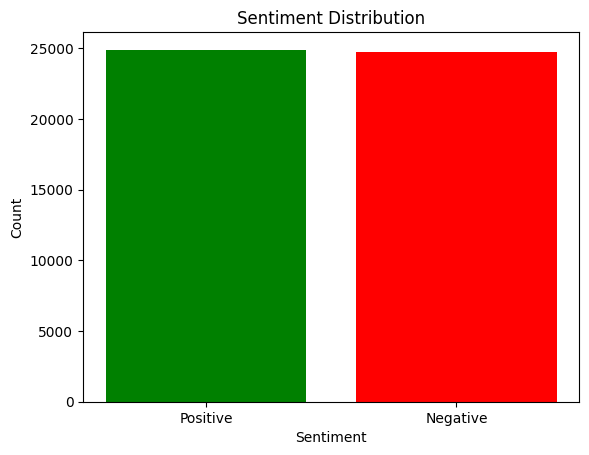

In [ ]:
import matplotlib.pyplot as plt

# Count the number of positive and negative sentiment labels
sentiment_counts = imdb['sentiment'].value_counts()

# Plot the distribution of sentiment labels
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.xticks(sentiment_counts.index, ['Positive', 'Negative'])
plt.show()


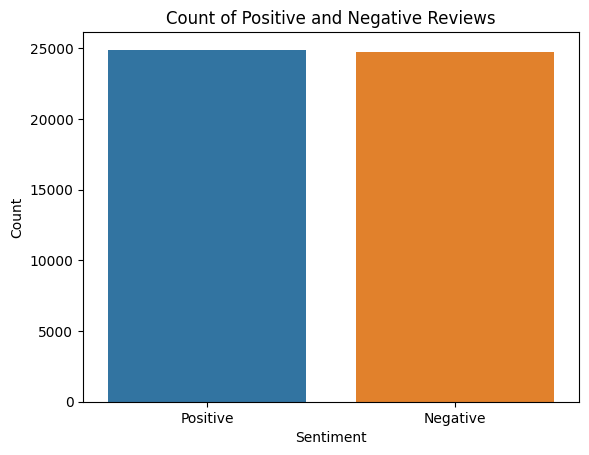

In [ ]:
import seaborn as sns

# Display the count of positive and negative reviews
sns.countplot(x='sentiment', data=imdb)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Positive and Negative Reviews')
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.show()


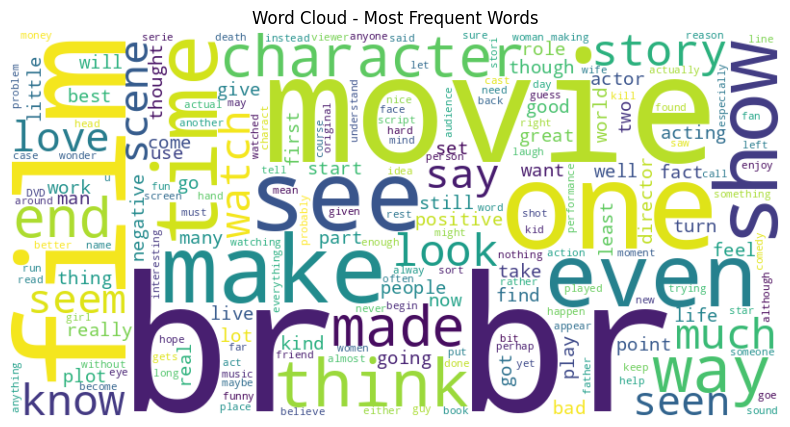

In [ ]:
from wordcloud import WordCloud

# Generate a word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(imdb['preprocessed_review']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Most Frequent Words')
plt.show()


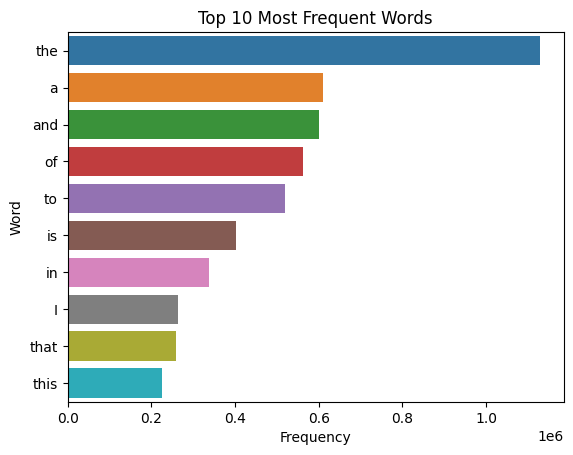

In [ ]:
from collections import Counter

# Illustrate the top N most frequent words
top_n = 10  # Change N to the desired number of top words
word_counts = Counter(' '.join(imdb['preprocessed_review']).split())
top_words = word_counts.most_common(top_n)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

sns.barplot(x='Frequency', y='Word', data=top_words_df)
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title(f'Top {top_n} Most Frequent Words')
plt.show()


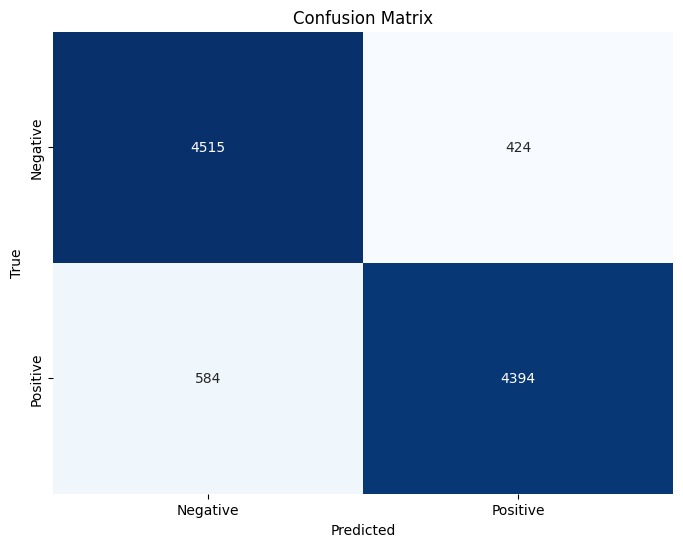

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred_bow)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


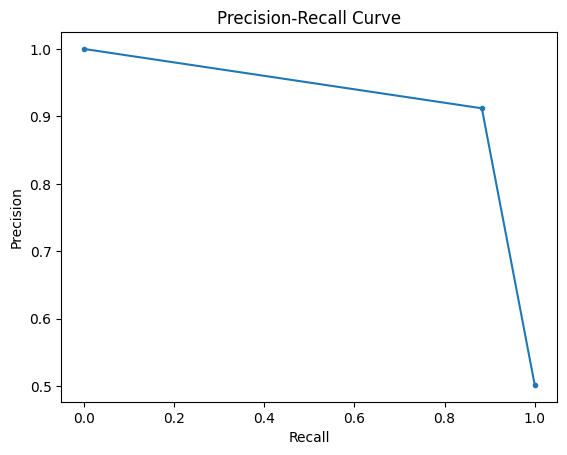

In [ ]:
from sklearn.metrics import precision_recall_curve

# Map 'negative' to 0 and 'positive' to 1 in y_test
y_test_binary = y_test.map({'negative': 0, 'positive': 1})

# Map 'negative' to 0 and 'positive' to 1 in y_pred_bow
y_pred_bow_binary = pd.Series(y_pred_bow).map({'negative': 0, 'positive': 1}).to_numpy()

# Calculate precision and recall using y_pred_bow_binary
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_bow_binary)

# Plot the precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


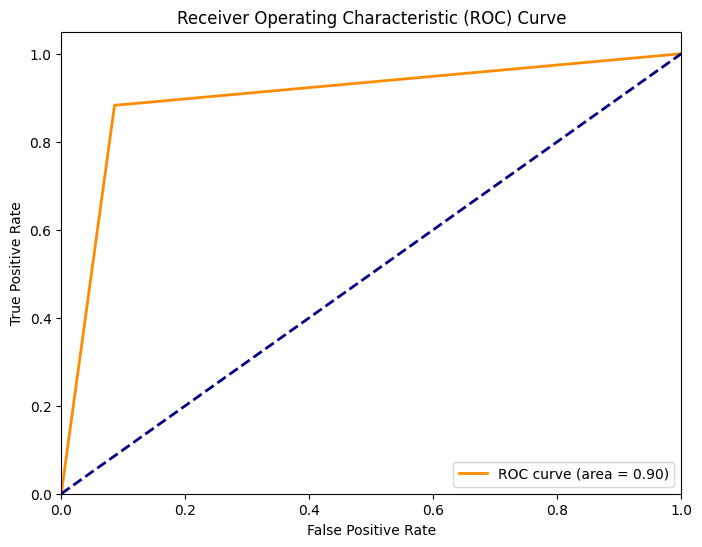

In [ ]:
from sklearn.metrics import roc_curve, auc

# Map 'negative' to 0 and 'positive' to 1 in y_test
y_test_binary = y_test.map({'negative': 0, 'positive': 1})

# Map 'negative' to 0 and 'positive' to 1 in y_pred_bow
y_pred_bow_binary = pd.Series(y_pred_bow).map({'negative': 0, 'positive': 1}).to_numpy()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_bow_binary)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
